# Library and Data Import

In [1]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Fetch the dataset
car_dataset = fetch_ucirepo(id=19)

# Data unpacking
X = car_dataset.data.features
y = car_dataset.data.targets

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1,random_state=12)

# variable information 
print(car_dataset.variables) 

       name     role         type demographic  \
0    buying  Feature  Categorical        None   
1     maint  Feature  Categorical        None   
2     doors  Feature  Categorical        None   
3   persons  Feature  Categorical        None   
4  lug_boot  Feature  Categorical        None   
5    safety  Feature  Categorical        None   
6     class   Target  Categorical        None   

                                         description units missing_values  
0                                       buying price  None             no  
1                           price of the maintenance  None             no  
2                                    number of doors  None             no  
3              capacity in terms of persons to carry  None             no  
4                           the size of luggage boot  None             no  
5                        estimated safety of the car  None             no  
6  evaulation level (unacceptable, acceptable, go...  None             no  

In [2]:
car_dataset.metadata

## Data Exploration

In [3]:
print(type(X))
print(type(y))

In [4]:
print(f"{X.describe()} \n")

X.sample(10)

In [5]:
df = pd.concat([X,y],axis=1)
print(df.sample(10))

print("\n===== Number of occurences in each unique class =====")
print(df['class'].value_counts())

In [6]:
df_train = pd.concat([X_train,y_train],axis=1)
print(df_train.shape)
print(df_train['class'].value_counts())

df_test = pd.concat([X_test,y_test],axis=1)
print(df_test.shape)

(1555, 7)
class
unacc    1087
acc       347
vgood      61
good       60
Name: count, dtype: int64
(173, 7)


# Naive Bayes algorithm

In a Naives Bayes classifier, one can learn the probability that an outcome happens given the conditions of the feature. Taken the tennis example, when given that the day is sunny (S), temperature is cool (C), humidity is high (H), and wind is strong (St), the desired output is the probability that players come to the court. Using Naive Bayes assumption, one can calculate this probability as 

$$p(Play\_Tennis = Y|Sunny,Cool,High,Strong) = p(Y)\times p(S|Y)\times p(C|Y)\times p(H|Y)\times p(St|Y)$$

The prior probability of Play_Tennis = Y is calculated as the number of yes occurences over the total number of samples. The conditional probabilities (such as $p(S|Y)$) is determined from the given dataset as the number of occurences where Play_Tennis is Yes and Outlook is Sunny over the total number of occurences where Play_Tennis is Yes. 
$$p(Outlook = Sunny|Play\_Tennis=Yes) = \frac{\text{\# S and Y}}{\text{\# Y}}$$


In the car evaluation example, there are three outcomes - unacceptable, acceptable, good, and vgood. The categories of the features were explored in the previous step and reported here
* buying: The buying price has 4 categories - low, med, high, and vhigh
* maint: The maintenance price has the similar 4 categories
* doors: The number of doors has 4 categories - 2, 3, 4, and 5more
* person: The number of passenger capacity has 3 categories - 2, 4, and more
* lug_boot: The size of luggage boot has 3 categories - small, med, and big
* safety: The estimated car safety has 3 categories - low, med, and high

In this example, the relative probability of an instance belong to a class is found as
$$p(class | \text{feature 1, feature 2, ... feature n}) = p(class)\prod_{i=1}^n p(\text{feature i}|class)$$

The class with the highest probability is the class that the instance belongs to. To implement the Naive Bayes classifier, I will then need to be able to:
* Find the prior probabilities of each class happening. This is simple since I just need to find the number of instances that belongs to a class and the size of the training dataset
* Find the conditional probability of p(feature i | class). This is a bit more involved since I will need to consider each feature value given that the instance belongs to a class -

# Functional implementation of Naive Bayes

## Functions for determining prior and conditional probabilities 

In [ ]:
def find_prior_probs(df, label_column, minority_class = None):
    '''
    This function finds the prior probability of each class in the dataframe and report them in a dictionary

    Parameters:
    - df (pd dataframe): DataFrame from which the probability is determined
    - label_colum (str): name of the class/label column
    - minority_class (dict): a dictionary containing the name of the minority classes (keu) and the upweighting factor corresponding to the class as (value)

    Returns:
    - class_prior (dict): the dictionary containing class (key) and their corresponding prior probabilities (value)
    '''
    classes = df[label_column].unique()                 # List of the classes
    num_instances = len(df)
    class_prior_probs = {}

    for class_value in classes:
        class_count = df[df[label_column]==class_value].shape[0]
        
        # if there is a weighting factor defined for the current class in the minority_class then use the value as the factor, else 1 (no scaling)
        upweight_factor = minority_class[class_value] if class_value in minority_class else 1      
        class_prior_probs[str(class_value)] = class_count / num_instances * upweight_factor

    return class_prior_probs

def find_cond_probs(df, label_column):
    classes = df[label_column].unique()

    feature_cond_probs = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
    '''This is a nested dictionary of the following structure
        - Level 1 - Class Values: This level has the class values and the next dictionary level as the key-value pair
            - Level 2 - Feature Names: This level of dictionary has the feature name and the next dictionary level as the key-value pair
                - Level 3 - Feature Values: This level of dictionary has the feature value and the conditional probabilities P(feature == feature value | class == class value) as the key-value pair 
    '''

    # Considering the conditional probability feature by feature
    for feature in df.columns:
        # Skip this step if the feature is the label column of the dataframe
        if feature == label_column:
            pass
        
        # Iterate over each class c of the dataframe to find the conditional probabilities of each feature P(feature = value | class)
        for c in classes: 
            df_subset = df[df[label_column]==c]                         # Subset of the dataframe where class has the value c
            feature_count = df_subset[feature].value_counts()           # Get a series with the number of instances of each feature value in the subset

            # Iterate over all the feature values and calculate the conditional probabilities of each value 
            for value, count in feature_count.items():                  
                feature_cond_probs[c][feature][value] = count / len(df_subset)

    return feature_cond_probs

## Determine the prior and conditional probabilities of all cases
This section shows the result of the functions <code>find_prior_probs()</code> and <code>find_cond_probs()</code>, which determine the prior and conditional probabilities for all classes and all probability 
$$P(\text{feature values}|\text{class values})$$

In [12]:
# Define a dictionary with the weighting factors for the minority classes
minority_class = {
    # "acc": 3,
    "good": 1,
    "vgood": 1
}

# Find the prior probability with the weighting factor
prior_probs = find_prior_probs(df_train,'class',minority_class=minority_class)

for key, value in prior_probs.items():
    print(f"The prior probability of class = {key} is {value*100:.3f}%")

The prior probability of class = unacc is 69.904%
The prior probability of class = acc is 22.315%
The prior probability of class = good is 3.859%
The prior probability of class = vgood is 3.923%


In [65]:
cond_probs = find_cond_probs(df_train,label_column='class')
cond_probs

count = 1
for key_1, value_1 in cond_probs.items():
    for key_2, value_2 in value_1.items():
        for key_3, value_3 in value_2.items():
                print(f"{count} \t p({key_2}=={key_3}|{key_1}) = {value_3:.3f}")
                count += 1

1 	 p(buying==vhigh|unacc) = 0.301
2 	 p(buying==high|unacc) = 0.266
3 	 p(buying==med|unacc) = 0.221
4 	 p(buying==low|unacc) = 0.213
5 	 p(maint==vhigh|unacc) = 0.305
6 	 p(maint==high|unacc) = 0.259
7 	 p(maint==low|unacc) = 0.222
8 	 p(maint==med|unacc) = 0.215
9 	 p(doors==2|unacc) = 0.264
10 	 p(doors==3|unacc) = 0.249
11 	 p(doors==5more|unacc) = 0.244
12 	 p(doors==4|unacc) = 0.243
13 	 p(persons==2|unacc) = 0.472
14 	 p(persons==more|unacc) = 0.275
15 	 p(persons==4|unacc) = 0.253
16 	 p(lug_boot==small|unacc) = 0.369
17 	 p(lug_boot==med|unacc) = 0.322
18 	 p(lug_boot==big|unacc) = 0.309
19 	 p(safety==low|unacc) = 0.489
20 	 p(safety==med|unacc) = 0.284
21 	 p(safety==high|unacc) = 0.226
22 	 p(class==unacc|unacc) = 1.000
23 	 p(buying==med|acc) = 0.300
24 	 p(buying==high|acc) = 0.277
25 	 p(buying==low|acc) = 0.233
26 	 p(buying==vhigh|acc) = 0.190
27 	 p(maint==med|acc) = 0.300
28 	 p(maint==high|acc) = 0.274
29 	 p(maint==low|acc) = 0.236
30 	 p(maint==vhigh|acc) = 0.190

In [66]:
def naive_bayes_classifier(prior_probs, cond_probs, instances):
    '''
    This function is used for classifying an instance

    Parameters
    - cond_probs: the 3-tier dictionary structure returned by the find_cond_probs() function. This structure represents the conditional probabilities P(features | classes) and has the structure of [class value][feature][feature value]
    - instance: a dictionary representing a data point ()
    '''

    # Get the list of classes (from the cond_probs structures)
    classes = []
    for item in cond_probs.items():
        classes.append(item[0])

    # List of empty dictionaries to store the probabilities of the instance belong to each class
    class_probs = [{}] * len(instances)                                        
    
    for index, instance in enumerate(instances):
        # Iterate over each class to find the prior probability 
        for c in classes:
            class_probs[index][c] = prior_probs[c]                     # p(class==c)

            # Iterate over each feature in the instance to find the accumulative of conditional probabilties
            for feature,value in instance.items():
                class_probs[index][c] *= max(cond_probs[c][feature][value],1e-6)       # In case of zero probability, use a small number
        
        class_probs[index] = max(class_probs[index], key=class_probs[index].get)

    return class_probs

## Test the Naive Bayes Classifier

Print out some sample instances in the testing dataset


In [49]:
test_instances = df_test.iloc[149:161].reset_index(drop=True)
test_instances

In [13]:
# Sample some random test_instances and drop the index to later concatenate with the predicted label
test_instances = df_test.reset_index(drop=True)
test_instance_features = test_instances.drop('class',axis =1).to_dict(orient='records')
test_instance_labels = test_instances['class'].values


prediction = naive_bayes_classifier(prior_probs=prior_probs,
                                    cond_probs=cond_probs,
                                    instances=test_instance_features)

prediction_df = pd.DataFrame(prediction, columns=["Predicted_Class"])
prediction_result = pd.concat([test_instances,prediction_df],axis=1)

prediction_result[['class','Predicted_Class']].iloc[140:150]


,class,Predicted_Class
140,acc,acc
141,unacc,unacc
142,unacc,unacc
143,unacc,unacc
144,unacc,unacc
145,vgood,vgood
146,unacc,unacc
147,unacc,unacc
148,unacc,unacc
149,good,acc


## Performance evaluation and visualization

In the following code block, I will visualize the testing performance of the Naive Bayes Classifier developed using a confusion matrix and accuracy score

Accuracy score: 86.71%


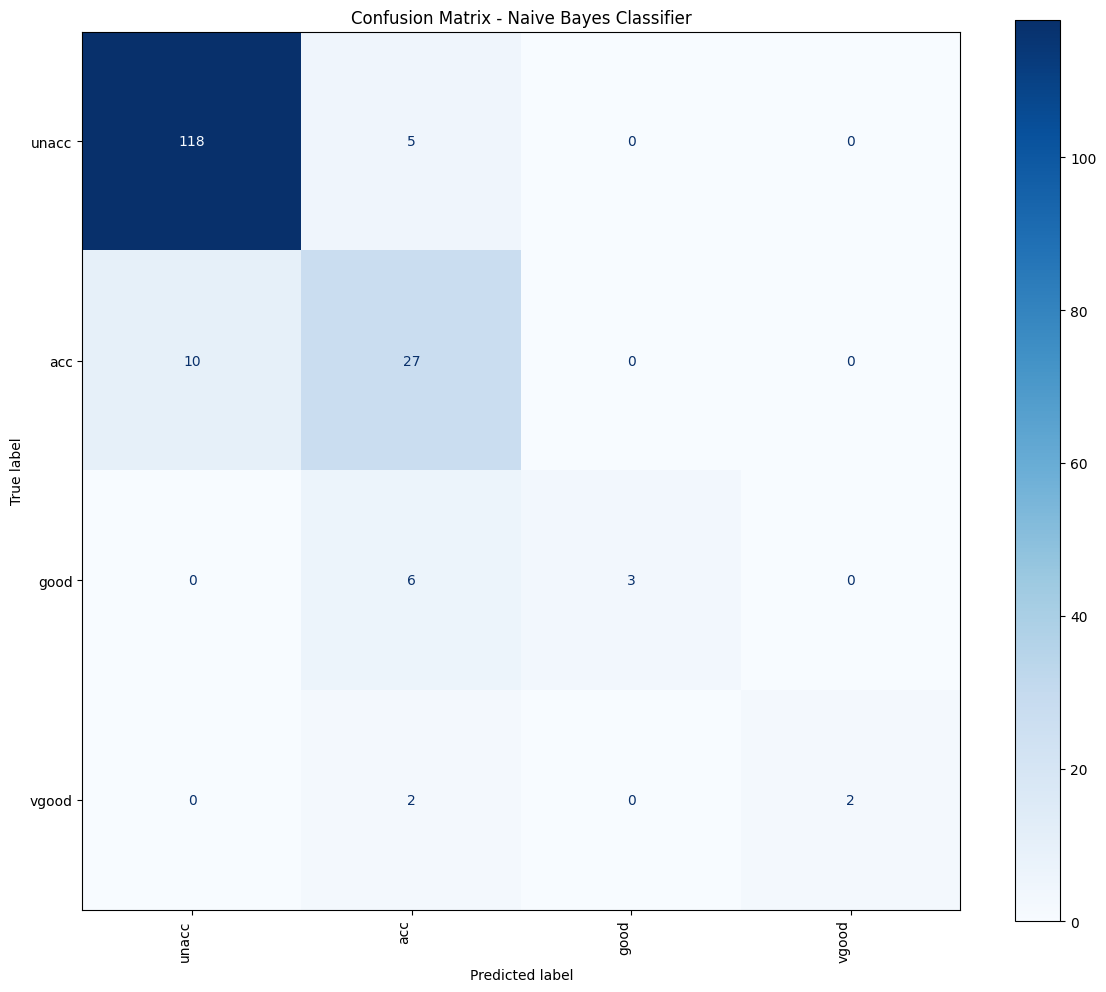


Classification Report:
               precision    recall  f1-score   support

       unacc       0.92      0.96      0.94       123
         acc       0.68      0.73      0.70        37
        good       1.00      0.33      0.50         9
       vgood       1.00      0.50      0.67         4

    accuracy                           0.87       173
   macro avg       0.90      0.63      0.70       173
weighted avg       0.87      0.87      0.86       173



In [14]:
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

label_true = prediction_result['class']
label_predicted = prediction_result['Predicted_Class']
accuracy = accuracy_score(label_true,label_predicted)
print(f"Accuracy score: {accuracy*100:.2f}%")

class_labels = ['unacc', 'acc', 'good', 'vgood']
cm = confusion_matrix(label_true,label_predicted ,labels = class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
fig = disp.ax_.get_figure()
fig.set_figwidth(12)
fig.set_figheight(10) 
plt.title("Confusion Matrix - Naive Bayes Classifier")
plt.xticks(rotation=90, ha='right')                     # Rotate x labels for better readability
plt.yticks(rotation=0)                                  # Keep y labels horizontal

plt.tight_layout()
plt.show()

report = classification_report(label_true, label_predicted, labels = class_labels, target_names= class_labels)
print("\nClassification Report:\n", report)

# Naives Bayes Classifier - OOP approach

As can be seen in the functional implementation of the Naives Bayes, one need to run the find_prior_probs() and find_cond_probs() functions first before passing them into the final naive_baye_classifier() to predict an instance. This approach can be deemed as unwieldy for downstream application. 

Inspired by the approach that machine learning libraries such as Tensorflow adopted, the following section shows the OOP implementation of Naive Bayes. In this approach, I will define a blueprint for a NaiveBayesClassifier() object, which stores attributes such as the classes, prior probabilities, and conditional probabilities learned from running a fit() method. Afterward, a predict() method can be run on a list of testing instances to provide prediction 